In [1]:
from pathlib import Path
import datetime as dt
import re
from html import escape, unescape
from difflib import Differ
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [6.0, 4.0] # Default: [6.0, 4.0]

In [2]:
def create_relative_time_column(df):

    df['Relative_time'] = dt.timedelta(seconds=0)  # Setting all the rows to 0, but only the first row will remain 0

    for i in range(1, len(df)):
        diff = df.index[i] - df.index[i-1]
        if diff.seconds > 600:
            diff = dt.timedelta(seconds=600)
        accumulated = df.Relative_time.iloc[i-1] + diff
        df.Relative_time.iat[i] = accumulated
    
    #df['Relative_time_seconds'] = df.Relative_time.apply(lambda x: x.seconds)
    
    df['Active_time'] = df.index[0] + df.Relative_time

In [4]:
def fill_nan_columns(df):
    # Filling NaNs
    df.update(df.filter(regex='^SourceEdit\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no SourceEdit event
    df.update(df.filter(regex='^JunitTest\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no JunitTest event
    df.update(df.filter(regex='^Launch\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no Launch event
    
    # Forward fill
    df.update(df.filter(regex='^SizeMeasure\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'SizeMeasure'
    df.update(df.filter(regex='^WarningCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'WarningCount'
    df.update(df.filter(regex='^Completion\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'Completion'
    df.update(df.filter(regex='^SuccessCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'SuccessCount'
    df.update(df.filter(regex='^FailureCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'FailureCount'
    df.update(df.filter(regex='^JunitTest_ErrorCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'JunitTest_ErrorCount'
    df.update(df.filter(regex='^SourceEdit_ErrorCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'JunitTest_ErrorCount'

In [5]:
def aggregate_columns(df):
    # Setting SourceEdit and JunitTest to 1 where any of the SourceEdit# or JunitTest# columns are 1
    df['SourceEdit'] = 0
    df.SourceEdit.iloc[np.where(df.filter(regex='^SourceEdit\d{1,}$') == 1)[0]] = 1
    df['JunitTest'] = 0
    df.JunitTest.iloc[np.where(df.filter(regex='^JunitTest\d{1,}$') == 1)[0]] = 1
    df['Launch'] = 0
    df.Launch.iloc[np.where(df.filter(regex='^Launch\d{1,}$') == 1)[0]] = 1
    
    df['TotalSizeMeasure'] = df.filter(regex='^SizeMeasure\d{1,}$').sum(axis=1)
    # We get the total completion by averaging all the Completion columns. Not skipping NaNs
    df['TotalCompletion'] = df.filter(regex='^Completion\d{1,}$').mean(skipna=False, axis=1)
    # Aggregating ErrorCount columns
    df['TotalJunitTest_ErrorCount'] = df.filter(regex='^JunitTest_ErrorCount\d{1,}$').sum(axis=1)
    df['TotalSourceEdit_ErrorCount'] = df.filter(regex='^SourceEdit_ErrorCount\d{1,}$').sum(axis=1)
    # Creating a total ErrorCount column
    df['TotalErrorCount'] = df.TotalJunitTest_ErrorCount + df.TotalSourceEdit_ErrorCount

In [43]:
def patch(original, edit, start, end):
    print('Original:\n', original)
    print('Before:\n', original[:start])
    print('Inserted:\n', edit)
    print('After:\n', original[end + 1:])
    print('Start:', start)
    print('End:', end)
    print(len(original))
    print(len(edit))
    print('Test:', (start==len(original) and len(edit)==0 and abs(end + 1)==len(original)))
    if len(edit)==0 and start==len(original) and abs(end + 1)==len(original):
        # There is no edit, and because both start and end is the same absolute value as original str length we have no deletion
        # We just return the original to prevent duplicated code
        return original
    patched = original[:start] + edit + original[end + 1:]
    return patched

In [7]:
differ = Differ()
def get_diff_length(old, new):
    diff = differ.compare(old, new)
    length = 0
    for i in diff:
        if i.startswith('+') or i.startswith('-'):
            length += 1
    return length

In [9]:
# 'data/csv/oving5/1395669706/Partner.csv'
df = pd.read_csv('data/csv/oving5/0141126194/Partner.csv', index_col=0, parse_dates=True)
#df = pd.read_csv('data/csv/oving5/0141126194/Card.csv', index_col=0, parse_dates=True)
# Merge duplicate indices (same exact timestamps)
df = df.groupby(level=0, sort=False).first()

In [10]:
df.isnull().sum()

SourceEdit1               28
SizeMeasure1              28
SourceEdit_ErrorCount1    28
WarningCount1             28
StoredString1             41
Start1                    29
End1                      29
JunitTest1                47
SuccessCount1             47
FailureCount1             47
JunitTest_ErrorCount1     47
Completion1               47
dtype: int64

In [11]:
df[['StoredString1', 'StoredString2', 'Start2', 'End2', 'StoredString3', 'Start3', 'End3']]

KeyError: "['StoredString2' 'Start2' 'End2' 'StoredString3' 'Start3' 'End3'] not in index"

In [11]:
df.StoredString2

2017-02-23 22:56:38    package objectstructures;\r\n\r\nimport java.u...
2017-02-23 22:57:24                                                  NaN
2017-02-23 22:59:26                                                  NaN
2017-02-23 22:59:29    public void deal(CardHand cardHand, int n) {\r...
2017-02-23 23:00:53                                                  NaN
2017-02-23 23:02:30                                                  NaN
2017-02-23 23:03:17                                                  NaN
2017-02-23 23:13:12    for (int i = allCards.length - 1; i > allCards...
2017-02-23 23:13:40                                                  NaN
2017-02-23 23:13:51                                                  NaN
2017-02-23 23:14:37                                                  NaN
2017-02-23 23:15:51                                                  NaN
2017-02-23 23:15:53                                                  NaN
2017-02-23 23:15:56                                

In [44]:
for column in df.filter(regex='^StoredString\d{1,}$').columns:
    print(column.upper())
    # Getting a Pandas Series object for the given column. Copy because we will alter it!
    stored_string_series = df[column].copy()
    # Removing all references to "\r" (carriage return). Hacky?
    stored_string_series = stored_string_series.str.replace('\r','')
    # Getting integer index of first valid index row
    first_valid = stored_string_series.index.get_loc(stored_string_series.first_valid_index())
    # Creating a deepcopy Series for the patched source code
    patched_series = stored_string_series.copy()
    # Setting everything except the first value to NaN
    patched_series.iloc[first_valid + 1:] = np.nan
    # Getting the start and end columns for the current stored string column:
    # FIXME: Hacky?
    # First, check if there is more than one storedString value. If not, we don't have any 'ReplaceSubstringEdit'
    # and thus no start or end columns
    file_number = ''.join(filter(str.isdigit, column))
    if stored_string_series.count() > 1:
        start_series = df['Start' + file_number]
        end_series = df['End' + file_number]
    else:
        print('This file has only been edited once, skipping.')
        df['SourceCode' + file_number] = patched_series.ffill()
        continue
    character_diff_series = pd.Series(index=stored_string_series.index)
    for row_idx in range(first_valid + 1, len(patched_series)):
        edit = stored_string_series.iloc[row_idx]
        if pd.isnull(edit):
            if not pd.isnull(start_series.iloc[row_idx]) and not pd.isnull(end_series.iloc[row_idx]):
                # We do have a start and end integer. Set edit to empty str since we are removing
                edit = ''
            else:
                # We just fill it with the latest patched value here to always have a value, and go to next iteration
                patched_series.iat[row_idx] = patched_series.iloc[row_idx - 1]
                continue
        #print('SizeMeasure:', df['SizeMeasure' + file_number].iloc[row_idx])
        print('-'*10)
        print('Index:', patched_series.index.values[row_idx])
        patched_series.iat[row_idx] = patch(patched_series.iloc[row_idx - 1], edit,
                                            int(start_series.iloc[row_idx]), int(end_series.iloc[row_idx]))
        print(patched_series.iloc[row_idx])
        
        # Get the number of edited characters (added, deleted, changed, moved etc.)
        character_diff_series.iat[row_idx] = get_diff_length(patched_series.iloc[row_idx - 1],
                                                                   patched_series.iloc[row_idx])
        
    # Naming convention for the patch column
    df['SourceCode' + file_number] = patched_series
    df['character_diff' + file_number] = character_diff_series
    print('#'*20)

STOREDSTRING1
----------
Index: 2017-02-19T22:51:52.000000000
Original:
 package objectstructures;

public class Partner {
	
	private String name;
	private String partnerName;
	
	public Partner(String name, String partnerName) {
		this.name = name;
		this.partnerName = partnerName;
	}
	
	public String getName() {
		return name;
	}
	
	public String getPartnerName() {
		return partnerName;
	}

}

Before:
 package objectstructures;

public class Partner {
	
	private String name;
	private String partnerName;
	
	public Partner(String name, String partnerName) {
		this.name = name;
		this.partnerName = partnerName;
	}
	
	public String getName() {
		return name;
	}
	
	public String getPartnerName() {
		return partnerName;
	}

Inserted:
 	
	
	

After:
 

}

Start: 321
End: -5
324
6
Test: False
package objectstructures;

public class Partner {
	
	private String name;
	private String partnerName;
	
	public Partner(String name, String partnerName) {
		this.name = name;
		this.partnerName = partne

In [45]:
df.SourceCode1

2017-02-19 22:50:21    package objectstructures;\n\npublic class Part...
2017-02-19 22:51:52    package objectstructures;\n\npublic class Part...
2017-02-19 22:52:00    package objectstructures;\n\npublic class Part...
2017-02-19 22:53:53    package objectstructures;\n\npublic class Part...
2017-02-19 22:54:30    package objectstructures;\n\npublic class Part...
2017-02-19 22:54:33    package objectstructures;\n\npublic class Part...
2017-02-19 22:55:03    package objectstructures;\n\npublic class Part...
2017-02-19 22:55:04    package objectstructures;\n\npublic class Part...
2017-02-19 22:55:17    package objectstructures;\n\npublic class Part...
2017-02-19 22:55:18    package objectstructures;\n\npublic class Part...
2017-02-19 22:56:22    package objectstructures;\n\npublic class Part...
2017-02-19 22:56:23    package objectstructures;\n\npublic class Part...
2017-02-19 22:56:48    package objectstructures;\n\npublic class Part...
2017-02-19 22:56:50    package objectstructures;\n\

In [48]:
df.character_diff1[:]

2017-02-19 22:50:21      NaN
2017-02-19 22:51:52      7.0
2017-02-19 22:52:00      NaN
2017-02-19 22:53:53     18.0
2017-02-19 22:54:30      9.0
2017-02-19 22:54:33      NaN
2017-02-19 22:55:03     55.0
2017-02-19 22:55:04      NaN
2017-02-19 22:55:17     14.0
2017-02-19 22:55:18      NaN
2017-02-19 22:56:22     74.0
2017-02-19 22:56:23      NaN
2017-02-19 22:56:48     56.0
2017-02-19 22:56:50      NaN
2017-02-19 22:58:56     30.0
2017-02-19 22:58:57      NaN
2017-02-19 22:59:06      1.0
2017-02-19 22:59:07      NaN
2017-02-19 22:59:11     27.0
2017-02-19 23:01:28     39.0
2017-02-19 23:01:29      NaN
2017-02-19 23:01:33     40.0
2017-02-19 23:02:35     28.0
2017-02-19 23:02:37      NaN
2017-02-19 23:02:41     27.0
2017-02-19 23:04:24     31.0
2017-02-19 23:04:25      NaN
2017-02-19 23:04:29    230.0
2017-02-19 23:04:30      NaN
2017-02-19 23:05:21     33.0
                       ...  
2017-02-20 08:36:08    153.0
2017-02-20 08:39:22    215.0
2017-02-20 08:39:32      7.0
2017-02-20 08:

# Experiments

In [17]:
df = pd.read_csv('data/csv/oving5/1395669706/Partner.csv', index_col=0, parse_dates=True)

In [18]:
fill_nan_columns(df)

In [19]:
create_relative_time_column(df)

In [20]:
aggregate_columns(df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
df

,SourceEdit1,SizeMeasure1,SourceEdit_ErrorCount1,WarningCount1,StoredString1,Start1,End1,JunitTest1,SuccessCount1,FailureCount1,...,Relative_time,Active_time,SourceEdit,JunitTest,Launch,TotalSizeMeasure,TotalCompletion,TotalJunitTest_ErrorCount,TotalSourceEdit_ErrorCount,TotalErrorCount
2017-02-22 19:54:17,1.0,6.0,0.0,0.0,package objectstructures;\r\n\r\npublic class ...,NaN,NaN,0.0,0.0,0.0,...,00:00:00,2017-02-22 19:54:17,1,0,0,6.0,0.0,0.0,0.0,0.0
2017-02-22 19:54:23,1.0,7.0,0.0,0.0,NaN,53.0,-6.0,0.0,0.0,0.0,...,00:00:06,2017-02-22 19:54:23,1,0,0,7.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:09,1.0,9.0,0.0,0.0,Partner() {\r\n\t\t\r\n\t},52.0,-6.0,0.0,0.0,0.0,...,00:06:52,2017-02-22 20:01:09,1,0,0,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:21,1.0,9.0,4.0,0.0,"String name,",60.0,-15.0,0.0,0.0,0.0,...,00:07:04,2017-02-22 20:01:21,1,0,0,9.0,0.0,0.0,4.0,4.0
2017-02-22 20:04:46,1.0,9.0,0.0,0.0,Partner partner,73.0,-15.0,0.0,0.0,0.0,...,00:10:29,2017-02-22 20:04:46,1,0,0,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:04:56,1.0,11.0,2.0,0.0,private name;\r\n\t,52.0,-53.0,0.0,0.0,0.0,...,00:10:39,2017-02-22 20:04:56,1,0,0,11.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:01,1.0,12.0,2.0,0.0,private Partner partner,67.0,-56.0,0.0,0.0,0.0,...,00:10:44,2017-02-22 20:05:01,1,0,0,12.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:03,1.0,12.0,0.0,2.0,String,60.0,-87.0,0.0,0.0,0.0,...,00:10:46,2017-02-22 20:05:03,1,0,0,12.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:55,1.0,13.0,0.0,2.0,this.name = name;\r\n\t\tthis.partner = partner;,144.0,-9.0,0.0,0.0,0.0,...,00:11:38,2017-02-22 20:05:55,1,0,0,13.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:57,1.0,15.0,0.0,2.0,\t,193.0,-6.0,0.0,0.0,0.0,...,00:11:40,2017-02-22 20:05:57,1,0,0,15.0,0.0,0.0,0.0,0.0


In [39]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [40]:
df['TotalRuns_ma10'] = df.TotalRuns.rolling(10).mean()

In [41]:
df.TotalRuns_ma10

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    NaN
2017-02-22 20:01:09    NaN
2017-02-22 20:01:21    NaN
2017-02-22 20:04:46    NaN
2017-02-22 20:04:56    NaN
2017-02-22 20:05:01    NaN
2017-02-22 20:05:03    NaN
2017-02-22 20:05:55    NaN
2017-02-22 20:05:57    0.0
2017-02-22 20:05:57    0.0
2017-02-22 20:06:21    0.0
2017-02-22 20:06:38    0.0
2017-02-22 20:06:45    0.0
2017-02-22 20:06:53    0.0
2017-02-22 20:07:02    0.0
2017-02-22 20:07:07    0.0
2017-02-22 20:07:09    0.0
2017-02-22 20:07:47    0.0
2017-02-22 20:07:52    0.0
2017-02-22 20:08:14    0.0
2017-02-22 20:08:31    0.0
2017-02-22 20:08:42    0.0
2017-02-22 20:09:02    0.0
2017-02-22 20:09:13    0.0
2017-02-22 20:09:41    0.0
2017-02-22 20:09:52    0.0
2017-02-22 20:10:01    0.0
2017-02-22 20:10:04    0.0
2017-02-22 20:10:20    0.0
                      ... 
2017-02-22 22:20:32    0.3
2017-02-22 22:20:45    0.3
2017-02-22 22:21:06    0.3
2017-02-22 22:21:07    0.3
2017-02-22 22:21:14    0.4
2017-02-22 22:21:17    0.5
2

In [42]:
df['SizeMeasure1_change'] = df.SizeMeasure1.diff().abs()

In [43]:
df.SizeMeasure1_change

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    1.0
2017-02-22 20:01:09    2.0
2017-02-22 20:01:21    0.0
2017-02-22 20:04:46    0.0
2017-02-22 20:04:56    2.0
2017-02-22 20:05:01    1.0
2017-02-22 20:05:03    0.0
2017-02-22 20:05:55    1.0
2017-02-22 20:05:57    2.0
2017-02-22 20:05:57    1.0
2017-02-22 20:06:21    2.0
2017-02-22 20:06:38    2.0
2017-02-22 20:06:45    2.0
2017-02-22 20:06:53    0.0
2017-02-22 20:07:02    4.0
2017-02-22 20:07:07    0.0
2017-02-22 20:07:09    2.0
2017-02-22 20:07:47    0.0
2017-02-22 20:07:52    2.0
2017-02-22 20:08:14    0.0
2017-02-22 20:08:31    2.0
2017-02-22 20:08:42    3.0
2017-02-22 20:09:02    2.0
2017-02-22 20:09:13    2.0
2017-02-22 20:09:41    0.0
2017-02-22 20:09:52    1.0
2017-02-22 20:10:01    0.0
2017-02-22 20:10:04    0.0
2017-02-22 20:10:20    2.0
                      ... 
2017-02-22 22:20:32    0.0
2017-02-22 22:20:45    0.0
2017-02-22 22:21:06    2.0
2017-02-22 22:21:07    0.0
2017-02-22 22:21:14    0.0
2017-02-22 22:21:17    0.0
2

In [44]:
df['SizeMeasure1_change_ma10'] = df.SizeMeasure1_change.rolling(10).mean()

In [45]:
df.SizeMeasure1_change_ma10

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    NaN
2017-02-22 20:01:09    NaN
2017-02-22 20:01:21    NaN
2017-02-22 20:04:46    NaN
2017-02-22 20:04:56    NaN
2017-02-22 20:05:01    NaN
2017-02-22 20:05:03    NaN
2017-02-22 20:05:55    NaN
2017-02-22 20:05:57    NaN
2017-02-22 20:05:57    1.0
2017-02-22 20:06:21    1.1
2017-02-22 20:06:38    1.1
2017-02-22 20:06:45    1.3
2017-02-22 20:06:53    1.3
2017-02-22 20:07:02    1.5
2017-02-22 20:07:07    1.4
2017-02-22 20:07:09    1.6
2017-02-22 20:07:47    1.5
2017-02-22 20:07:52    1.5
2017-02-22 20:08:14    1.4
2017-02-22 20:08:31    1.4
2017-02-22 20:08:42    1.5
2017-02-22 20:09:02    1.5
2017-02-22 20:09:13    1.7
2017-02-22 20:09:41    1.3
2017-02-22 20:09:52    1.4
2017-02-22 20:10:01    1.2
2017-02-22 20:10:04    1.2
2017-02-22 20:10:20    1.2
                      ... 
2017-02-22 22:20:32    0.4
2017-02-22 22:20:45    0.4
2017-02-22 22:21:06    0.5
2017-02-22 22:21:07    0.4
2017-02-22 22:21:14    0.3
2017-02-22 22:21:17    0.2
2

In [53]:
df['hypotese'] =df.SizeMeasure1_change_ma10 / df.TotalRuns_ma10

In [57]:
df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']

2017-02-22 20:22:11     3.500000
2017-02-22 20:22:17     6.000000
2017-02-22 20:23:40     5.333333
2017-02-22 20:23:43     4.000000
2017-02-22 20:23:55     7.500000
2017-02-22 20:24:06     6.500000
2017-02-22 20:24:27    14.000000
2017-02-22 20:24:58    13.000000
2017-02-22 20:25:03    14.000000
2017-02-22 20:25:15          inf
2017-02-22 20:25:17    12.000000
2017-02-22 20:31:15     9.000000
2017-02-22 20:31:16     4.500000
2017-02-22 20:31:27     4.500000
2017-02-22 20:31:29     2.000000
2017-02-22 20:31:44     1.666667
2017-02-22 20:31:46     1.000000
2017-02-22 20:31:47     0.600000
2017-02-22 20:31:48     0.333333
2017-02-22 20:31:58     0.333333
2017-02-22 20:32:06     0.600000
2017-02-22 20:32:12     0.400000
2017-02-22 20:32:32     0.750000
2017-02-22 20:32:38     0.600000
2017-02-22 20:34:23     1.250000
2017-02-22 20:34:25     0.800000
2017-02-22 20:35:48     1.000000
2017-02-22 20:35:51     1.000000
2017-02-22 20:35:56     1.333333
2017-02-22 20:35:58     1.000000
2017-02-22

In [48]:
df_slice = df['2017-02-22 20:21:00':'2017-02-22 20:40:00'].copy()

In [54]:
df_slice.hypotese.replace(np.inf, 100, inplace=True)

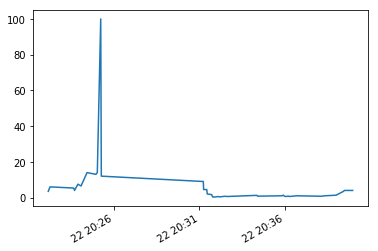

In [63]:
df_slice.hypotese.plot()

In [128]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

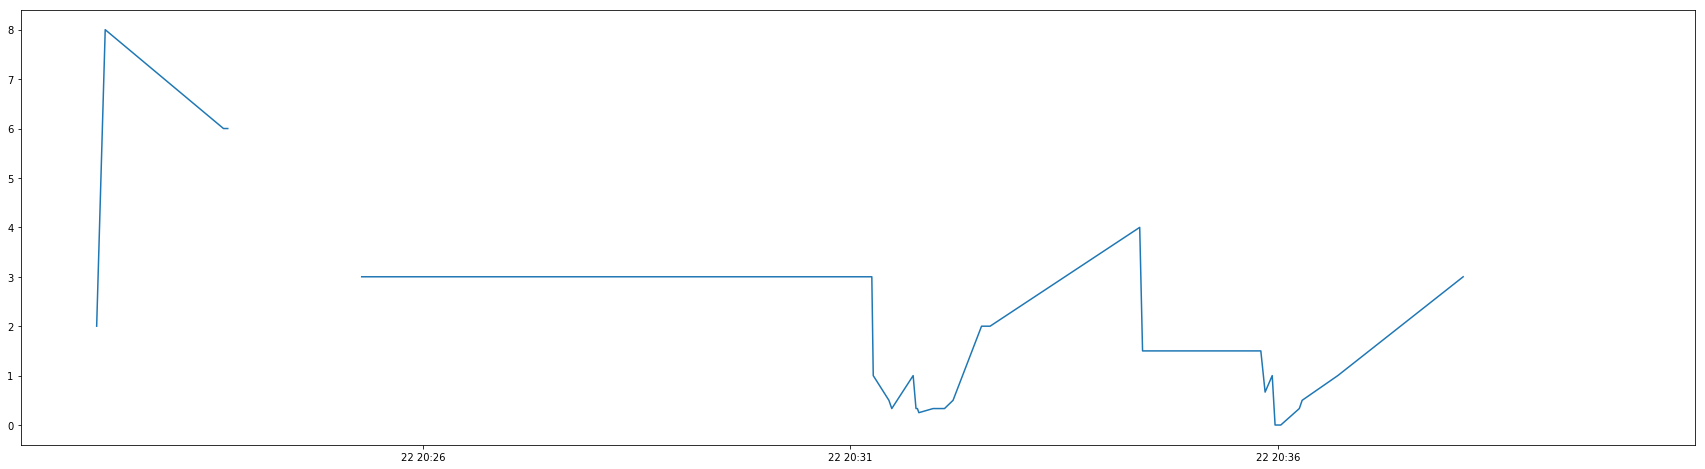

In [135]:
fig, ax = plt.subplots()
xtick_locator = AutoDateLocator(minticks=6)
xtick_formatter = AutoDateFormatter(xtick_locator, defaultfmt='%H:%M')
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.plot(df_slice2)
plt.show()

## Possible features:

### Changes in size measure divived by how many times the code has been run
Using a moving average of 10 of both the difference in size measure and the total runs (Junit + Launch)

### Changes in size measure since last run.
Accumulate the size measure changes (diff) and reset every time we reach a run (either Junit or Launch)

### Time since last run in relative time (?)